In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
from scipy import stats
import utils_last_session as utils
import seaborn as sns
import pingouin as pg
import matplotlib.cm as cm

import statsmodels.stats.power as smp
from statsmodels.stats.anova import AnovaRM


from natsort import index_natsorted

# plt.rcParams['font.family'] = 'Times New Roman'


path_figs = "./Figs/"

seq_length = 7 #Length of sequences

windowSizes = [1, 2, 3, 7]

digit_change = [2,3,4]

fingers = ['1', '2', '3', '4', '5'] #mapping of fingers to numbers

iti = 3000   #Inter trial interval
execTime = 10000 # msecs for each trial maximum
precueTime_interval = [600, 1000] # msecs for planning before movement 
hand = 2 #left or right hand

# total_sub_num = 10
sub_nums = [1, 2,3,4,5,6,7, 8, 9, 10, 11, 12, 13, 14]

excluded_block_n = 37 #The first block is excluded from the analysis, because it is a warmup block





In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker

def set_figure_style(scale="1col"):
    """
    Set figure styling based on publication constraints.
    
    Parameters:
        scale (str): Scale of the figure, choose from "1col", "1.5col", "2col".
                     - "1col" for 8.5cm
                     - "1.5col" for 11.6cm
                     - "2col" for 17.6cm
    """
    # Define width options in cm
    widths = {"1col": 7.62, "1.5col": 11.6, "2col": 16.5}
    
    if scale not in widths:
        raise ValueError("Invalid scale. Choose from '1col', '1.5col', or '2col'.")
    
    # Convert width from cm to inches (1 cm = 0.393701 inches)
    width_in = widths[scale] * 0.393701
    
    # Set figure size (width, height)
    # Assuming height proportional to width (Golden Ratio)
    golden_ratio = (5**0.5 - 1) / 2
    rcParams["figure.figsize"] = (width_in, width_in * golden_ratio)
    
    # Set font sizes
    rcParams["font.size"] = 10  # General font size
    # rcParams["font.size"] = 20  # General font size
    rcParams["axes.titlesize"] = 12  # Figure title
    # rcParams["axes.titlesize"] = 26  # Figure title
    rcParams["axes.labelsize"] = 9  # Axis main label
    # rcParams["axes.labelsize"] = 22  # Axis main label
    rcParams["xtick.labelsize"] = 7  # Tick labels
    # rcParams["xtick.labelsize"] = 16  # Tick labels
    rcParams["ytick.labelsize"] = 7
    # rcParams["ytick.labelsize"] = 16
    rcParams["legend.fontsize"] = 8  # Legend entries
    # rcParams["legend.fontsize"] = 20  # Legend entries
    rcParams["figure.titleweight"] = "bold"
    
    # Set stroke width
    rcParams["axes.linewidth"] = 0.75
    # rcParams["axes.linewidth"] = 1.5

    # rcParams["lines.linewidth"] = 3
    
    rcParams["xtick.major.width"] = 0.75
    # rcParams["xtick.major.width"] = 1.5
    rcParams["ytick.major.width"] = 0.75
    # rcParams["ytick.major.width"] = 1.5

    
    # Subpanel lettering size
    rcParams["text.usetex"] = False  # Set to True if using LaTeX
    rcParams["axes.formatter.use_mathtext"] = True  # Math text for scientific notation

def add_subpanel_label(ax, label, fontsize=20, position=(-0.1, 1.05)):
    """
    Add a subpanel label (e.g., 'a', 'b') to a subplot.
    
    Parameters:
        ax (Axes): Matplotlib Axes object.
        label (str): The label text.
        fontsize (int): Font size for the label.
        position (tuple): Position of the label in axes coordinates.
    """
    ax.text(position[0], position[1], label, transform=ax.transAxes, 
            fontsize=fontsize, fontweight="bold", va="top", ha="left")

###
set_figure_style(scale="1col")




In [4]:
subjs_list = utils.read_dat_files_subjs_list(sub_nums)

for subj in subjs_list: ###Adding IPIs
    utils.add_IPI(subj)

subjs = pd.concat(subjs_list) ###Merging all subjs into one dataframe
subjs.reset_index(inplace=True, drop=True)

subjs_presses = utils.finger_melt(subjs).rename(columns={'isError' : 'isTrialError'})

subjs['condition'] = subjs.apply(utils.seq_condition, axis=1)
subjs_presses['condition'] = subjs_presses.apply(utils.seq_condition, axis=1)

In [5]:
custom_palette = {
    'M': sns.color_palette('colorblind')[0],
    'S': sns.color_palette('colorblind')[7],
    'M+S': sns.color_palette('colorblind')[1],
    'M+S (changed)': sns.color_palette('colorblind')[3]
}


Window sizes 1 and 2: t-statistic = -3.9341440597871014, p-value = 0.0017120340991771835
Window sizes 2 and 3: t-statistic = -3.9195936143168546, p-value = 0.0017597529736477792
Window sizes 3 and 7: t-statistic = -0.16590200069386069, p-value = 0.8707864157927341


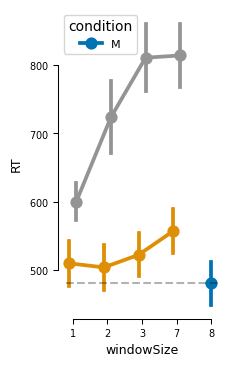

In [14]:
# set_figure_style(scale="1col")

set_figure_style("2col")

# fig, axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(fig.get_size_inches()[0]/3, fig.get_size_inches()[1] * 3 / 3)

subjs_correct = utils.remove_error_trials(subjs)
subjs_correct =utils.remove_first_block(subjs_correct)

subjs_correct = subjs_correct[subjs_correct['condition'] != 'M+S (changed)']

M_data = subjs_correct[subjs_correct['condition'] == 'M']
subjs_correct = subjs_correct[subjs_correct['condition'] != 'M']

#create cartesian product to replicate data for each window size
M_data = M_data.assign(key=1).merge(pd.DataFrame({'windowSize': windowSizes, 'key': 1}), on='key').drop('key', axis=1)
M_data = M_data.rename(columns={'windowSize_y': 'windowSize'})

M_data_grouped = M_data.groupby(['SubNum', 'condition', 'windowSize']).agg({
    'RT': 'median'
}).reset_index()

# select only one window size so plot as one point
M_data_grouped = M_data_grouped[M_data_grouped['windowSize'] == 1]
M_data_grouped['windowSize'] = 8

subjs_grouped = subjs_correct.groupby(['SubNum', 'condition', 'windowSize']).agg({
    'RT': 'median'
}).reset_index()

sns.pointplot(data = subjs_grouped, x = 'windowSize', y = 'RT', hue = 'condition', errorbar='se',
              dodge = 0.2, palette=custom_palette, legend=False)

sns.pointplot(data = M_data_grouped, x = 'windowSize', y = 'RT', hue = 'condition', errorbar='se',
              palette=custom_palette)

plt.hlines(M_data_grouped['RT'].mean(), -0.2, 4.2, color='black', linestyle='--', alpha = 0.3)

# plt.ylim(1000, 4000)
sns.despine(trim=True)



# paired t-test between consequtive window sizes
condition_to_test = 'S'
subjs_grouped = subjs_grouped[subjs_grouped['condition'] == condition_to_test]
for i in range(len(windowSizes)-1):
    windowSize1 = windowSizes[i]
    windowSize2 = windowSizes[i+1]

    data1 = subjs_grouped[subjs_grouped['windowSize'] == windowSize1]['RT']
    data2 = subjs_grouped[subjs_grouped['windowSize'] == windowSize2]['RT']

    t_stat, p_val = stats.ttest_rel(data1, data2)
    print(f"Window sizes {windowSize1} and {windowSize2}: t-statistic = {t_stat}, p-value = {p_val}")





# plt.savefig(path_figs + "MT_last_session.pdf", format = 'pdf', bbox_inches = 'tight')

plt.show()

paired t-test consequtive window sizes for condition S
Window sizes 1 and 2: t-statistic = 20.418498137050353, p-value = 2.924407951271745e-11
Window sizes 2 and 3: t-statistic = 1.7114736187793533, p-value = 0.11073154561432748
Window sizes 3 and 7: t-statistic = 1.8571801760519575, p-value = 0.08608114230058679
paired t-test between S and M+S conditions
TtestResult(statistic=10.927907339710895, pvalue=6.366643994598408e-08, df=13)
Horizon benefit for M+S condition
              F Value  Num DF  Den DF        Pr > F
windowSize  72.144429     3.0    39.0  5.694464e-16


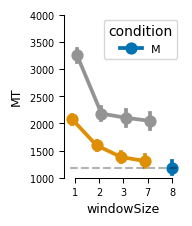

In [43]:
# set_figure_style(scale="1col")

set_figure_style("1.5col")

# fig, axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(fig.get_size_inches()[0]/3, fig.get_size_inches()[1] * 3 / 4)
# fig.set_size_inches(fig.get_size_inches()[0]/3, 1.691)


subjs_correct = utils.remove_error_trials(subjs)
subjs_correct = utils.remove_first_block(subjs_correct)

subjs_correct = subjs_correct[subjs_correct['condition'] != 'M+S (changed)']

M_data = subjs_correct[subjs_correct['condition'] == 'M']
subjs_correct = subjs_correct[subjs_correct['condition'] != 'M']

#create cartesian product to replicate data for each window size
M_data = M_data.assign(key=1).merge(pd.DataFrame({'windowSize': windowSizes, 'key': 1}), on='key').drop('key', axis=1)
M_data = M_data.rename(columns={'windowSize_y': 'windowSize'})

M_data_grouped = M_data.groupby(['SubNum', 'condition', 'windowSize']).agg({
    'MT': 'median'
}).reset_index()

# select only one window size so plot as one point
M_data_grouped = M_data_grouped[M_data_grouped['windowSize'] == 1]
M_data_grouped['windowSize'] = 8

subjs_grouped = subjs_correct.groupby(['SubNum', 'condition', 'windowSize']).agg({
    'MT': 'median'
}).reset_index()

sns.pointplot(data = subjs_grouped, x = 'windowSize', y = 'MT', hue = 'condition', errorbar='se',
              dodge = 0.2, palette=custom_palette, legend=False)

sns.pointplot(data = M_data_grouped, x = 'windowSize', y = 'MT', hue = 'condition', errorbar='se',
              palette=custom_palette)

plt.hlines(M_data_grouped['MT'].mean(), -0.2, 4.2, color='black', linestyle='--', alpha = 0.3)

plt.ylim(1000, 4000)
sns.despine(trim=True)



# paired t-test between consequtive window sizes
condition_to_test = 'S'
print(f"paired t-test consequtive window sizes for condition {condition_to_test}")
subjs_grouped = subjs_grouped[subjs_grouped['condition'] == condition_to_test]
for i in range(len(windowSizes)-1):
    windowSize1 = windowSizes[i]
    windowSize2 = windowSizes[i+1]

    data1 = subjs_grouped[subjs_grouped['windowSize'] == windowSize1]['MT']
    data2 = subjs_grouped[subjs_grouped['windowSize'] == windowSize2]['MT']

    t_stat, p_val = stats.ttest_rel(data1, data2)
    print(f"Window sizes {windowSize1} and {windowSize2}: t-statistic = {t_stat}, p-value = {p_val}")

# compare S and M+S conditions 
subjs_grouped = subjs_correct.groupby(['SubNum', 'condition']).agg({
    'MT': 'median'
}).reset_index()
print(f"paired t-test between S and M+S conditions")
data_S = subjs_grouped[subjs_grouped['condition'] == 'S']['MT']
data_M_plus_S = subjs_grouped[subjs_grouped['condition'] == 'M+S']['MT']
print(stats.ttest_rel(data_S, data_M_plus_S))

# horizon benefit for M+S condition
print(f"Horizon benefit for M+S condition")
subjs_grouped = subjs_correct[subjs_correct['condition'] == 'M+S'].groupby(['SubNum', 'windowSize']).agg({
    'MT': 'median'
}).reset_index()
res = AnovaRM(data=subjs_grouped, depvar='MT', subject='SubNum', within=['windowSize']).fit()
print(res.anova_table)





plt.savefig(path_figs + "MT_last_session.pdf", format = 'pdf', bbox_inches = 'tight')

plt.show()

Window sizes 1 and 2: t-statistic = 4.623049110542882, p-value = 0.0004772880645243248
Window sizes 2 and 3: t-statistic = 1.1720364243860615, p-value = 0.262214363159333
Window sizes 3 and 7: t-statistic = 0.902588043712427, p-value = 0.3831639093517588
Horizon benefit for M+S (changed) condition
              F Value  Num DF  Den DF        Pr > F
windowSize  16.066388     3.0    39.0  5.902749e-07


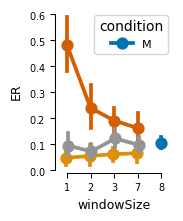

In [44]:
# set_figure_style(scale="2col")
set_figure_style("1.5col")


fig = plt.gcf()
fig.set_size_inches(fig.get_size_inches()[0]/3, fig.get_size_inches()[1] * 3/4)

subjs_not_crossed = subjs[subjs["isCross"] == False].copy()
subjs_not_crossed = utils.remove_first_block(subjs_not_crossed)
subjs_not_crossed['num_trials'] = 1
M_data = subjs_not_crossed[subjs_not_crossed['condition'] == 'M']
subjs_not_crossed = subjs_not_crossed[subjs_not_crossed['condition'] != 'M']

#create cartesian product to replicate data for each window size
M_data = M_data.assign(key=1).merge(pd.DataFrame({'windowSize': windowSizes, 'key': 1}), on='key').drop('key', axis=1)
M_data = M_data.rename(columns={'windowSize_y': 'windowSize'})

M_data_grouped = M_data.groupby(['SubNum', 'condition', 'windowSize']).agg({
    'isError': 'sum',
    'num_trials': 'sum'
}).reset_index()

# select only one window size so plot as one point
M_data_grouped = M_data_grouped[M_data_grouped['windowSize'] == 1]
M_data_grouped['windowSize'] = 8

subjs_grouped = subjs_not_crossed.groupby(['SubNum', 'condition', 'windowSize']).agg({
    'isError': 'sum',
    'num_trials': 'sum'
}).reset_index()
M_data_grouped['ER'] = M_data_grouped['isError'] / M_data_grouped['num_trials']
subjs_grouped['ER'] = subjs_grouped['isError'] / subjs_grouped['num_trials']

sns.pointplot(data = subjs_grouped, x = 'windowSize', y = 'ER', hue = 'condition', dodge = True, palette=custom_palette, legend=False)
sns.pointplot(data = M_data_grouped, x = 'windowSize', y = 'ER', hue = 'condition', palette=custom_palette)

sns.despine(trim=True)


# paired t-test between consequtive window sizes
condition_to_test = 'M+S (changed)'
subjs_grouped = subjs_grouped[subjs_grouped['condition'] == condition_to_test]
for i in range(len(windowSizes)-1):
    windowSize1 = windowSizes[i]
    windowSize2 = windowSizes[i+1]

    data1 = subjs_grouped[subjs_grouped['windowSize'] == windowSize1]['ER']
    data2 = subjs_grouped[subjs_grouped['windowSize'] == windowSize2]['ER']

    t_stat, p_val = stats.ttest_rel(data1, data2)
    print(f"Window sizes {windowSize1} and {windowSize2}: t-statistic = {t_stat}, p-value = {p_val}")

# horizon benefit for M+S condition
print(f"Horizon benefit for M+S (changed) condition")
changed_condition = subjs_grouped[subjs_grouped['condition'] == 'M+S (changed)']
res = AnovaRM(data=changed_condition, depvar='ER', subject='SubNum', within=['windowSize']).fit()
print(res.anova_table)

plt.savefig(path_figs + "ER_last_session.pdf", format = 'pdf', bbox_inches = 'tight')

# Press Analysis

comparing RT in S and M+S conditions
TtestResult(statistic=8.027475022349162, pvalue=2.1537400077953226e-06, df=13)
comparing RT in S and M+S (changed) conditions
TtestResult(statistic=-7.968425128009854, pvalue=2.3350493250602047e-06, df=13)
    SubNum      condition        ER  is_first_press_error  num_trials
0      1.0            M+S  1.000000                   0.0       240.0
1      2.0            M+S  1.000000                   0.0       240.0
2      3.0            M+S  0.991667                   2.0       240.0
3      4.0            M+S  1.000000                   0.0       240.0
4      5.0            M+S  1.000000                   0.0       240.0
5      6.0            M+S  0.995833                   1.0       240.0
6      7.0            M+S  1.000000                   0.0       240.0
7      8.0            M+S  0.987500                   3.0       240.0
8      9.0            M+S  1.000000                   0.0       240.0
9     10.0            M+S  0.995833                   1.0

/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_63908/3726868875.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  subjs_presses_errors = subjs_presses_copy.merge(subjs_presses_errors, on = ['SubNum', 'BN', 'TN', 'N'], how = 'left',
/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_63908/3726868875.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['num_trials'] = 1


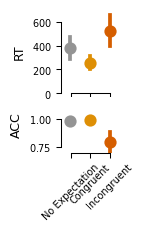

In [50]:
set_figure_style(scale="1col")

fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 2], 'hspace' : 0.05}, sharex=True)
fig.set_size_inches(fig.get_size_inches()[0]/4, fig.get_size_inches()[1] * 1)

# --------- IPI at changed pos -------------

presses_correct = utils.remove_error_trials_presses(subjs_presses)
presses_correct = utils.remove_first_block(presses_correct)

#set plette colors 
palette = sns.color_palette("colorblind", 4)
sns.set_palette(palette)

RT_data = pd.DataFrame({ 'SubNum': [], 'condition': [],'RT': []})

for condition, data in presses_correct.groupby('condition'):
    if condition == 'M':
        continue
    if condition == 'M+S (changed)':
        data = data[data['N'] - 1 - data['digitChangePos'] == 0]
    else:
        datas = {}
        for digitpos in digit_change:
            datas[digitpos] = data[data['N'] - 1 - digitpos == 0]
            # data['dist_to_change'] = data['N'] - 1 - digitpos
            # data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            # datas[digitpos] = data_new
        
        data = pd.concat(list(datas.values()), ignore_index=True)
    
    data = data.groupby(['SubNum']).agg({
        'IPI_Value': 'median'
    }).reset_index()

    data['condition'] = condition
    data['RT'] = data['IPI_Value']

    #append data to RT_data
    RT_data = pd.concat([RT_data, data], ignore_index=True)

# sort RT_data by condition such that changed is last
RT_data['condition'] = pd.Categorical(RT_data['condition'], categories=['S', 'M+S', 'M+S (changed)'], ordered=True)

# print(RT_data)

sns.pointplot(data = RT_data, x = 'condition', y = 'RT', errorbar='sd', dodge = True,
              label = condition, hue = 'condition', palette=custom_palette, ax=ax0)

print("comparing RT in S and M+S conditions")
print(stats.ttest_rel(RT_data[RT_data['condition'] == 'S']['RT'], RT_data[RT_data['condition'] == 'M+S']['RT']))
print("comparing RT in S and M+S (changed) conditions")
print(stats.ttest_rel(RT_data[RT_data['condition'] == 'S']['RT'], RT_data[RT_data['condition'] == 'M+S (changed)']['RT']))


# --------- Error rate at changed pos -------------
subjs_presses_errors = utils.remove_remaining_next_error_presses(subjs_presses).copy()
subjs_presses_errors = utils.remove_first_block(subjs_presses_errors)
subjs_presses_errors = subjs_presses_errors[subjs_presses_errors['isPressError'] == True]
subjs_presses_errors['is_first_press_error'] = True
subjs_presses_errors = subjs_presses_errors[['SubNum', 'BN', 'TN', 'N', 'is_first_press_error']]

subjs_presses_copy = subjs_presses.copy()
subjs_presses_copy = utils.remove_first_block(subjs_presses_copy)
subjs_presses_copy['is_first_press_error'] = False

subjs_presses_errors = subjs_presses_copy.merge(subjs_presses_errors, on = ['SubNum', 'BN', 'TN', 'N'], how = 'left', 
                                           suffixes=('', '_right')).fillna(False)
subjs_presses_errors['is_first_press_error'] = subjs_presses_errors['is_first_press_error_right']
subjs_presses_errors = subjs_presses_errors.drop(columns='is_first_press_error_right')

ER_data = pd.DataFrame({ 'SubNum': [], 'condition': [],'ER': []})

for condition, data in subjs_presses_errors.groupby('condition'):
    if condition == 'M':
        continue
    if condition == 'M+S (changed)':
        data = data[data['N'] - 1 - data['digitChangePos'] == 0]
    else:
        datas = {}
        for digitpos in digit_change:
            datas[digitpos] = data[data['N'] - 1 - digitpos == 0]
        
        data = pd.concat(list(datas.values()), ignore_index=True)
    
    data['num_trials'] = 1
    data = data.groupby(['SubNum']).agg({
        'is_first_press_error': 'sum',
        'num_trials': 'sum'
    }).reset_index()

    data['ER'] = 1 - data['is_first_press_error'] / data['num_trials']
    data['condition'] = condition

    # print(data)


    #append data to RT_data
    ER_data = pd.concat([ER_data, data], ignore_index=True)

# sort RT_data by condition such that changed is last
ER_data['condition'] = pd.Categorical(ER_data['condition'], categories=['S', 'M+S', 'M+S (changed)'], ordered=True)
print(ER_data)
sns.pointplot(data = ER_data, x = 'condition', y = 'ER', errorbar='sd', dodge = True,
                label = condition, hue = 'condition' ,palette=custom_palette, ax=ax1)


ax0.set_ylabel('RT')
ax1.set_ylabel('ACC')
plt.xlabel('')
plt.xticks(ticks= range(3), labels=['No Expectation', 'Congruent', 'Incongruent'], rotation=45)
# plt.ylim(0, 700)
ax0.set_ylim(0, 700)
# ax0.set_ylim(200, 700)
ax1.set_ylim([0.7, 1.2])
sns.despine(trim=True)

plt.savefig(path_figs + "RT_ER_changed_press.pdf", format = 'pdf', bbox_inches = 'tight')



In [64]:
# --------- Error rate at changed pos -------------
subjs_presses_errors = utils.remove_remaining_next_error_presses(subjs_presses).copy()
subjs_presses_errors = utils.remove_first_block(subjs_presses_errors)
subjs_presses_errors = subjs_presses_errors[subjs_presses_errors['isPressError'] == True]
subjs_presses_errors['is_first_press_error'] = True
subjs_presses_errors = subjs_presses_errors[['SubNum', 'BN', 'TN', 'N', 'is_first_press_error']]

subjs_presses_copy = subjs_presses.copy()
subjs_presses_copy = utils.remove_first_block(subjs_presses_copy)
subjs_presses_copy['is_first_press_error'] = False

subjs_presses_errors = subjs_presses_copy.merge(subjs_presses_errors, on = ['SubNum', 'BN', 'TN', 'N'], how = 'left', 
                                           suffixes=('', '_right')).fillna(False)
subjs_presses_errors['is_first_press_error'] = subjs_presses_errors['is_first_press_error_right']
subjs_presses_errors = subjs_presses_errors.drop(columns='is_first_press_error_right')


#rename M+S and S to unmasked 
subjs_presses_errors['condition'] = subjs_presses_errors['condition'].replace({'M+S': 'unmasked', 'S': 'unmasked'})

ER_data = pd.DataFrame({ 'SubNum': [], 'condition': [],'ER': []})

for condition, data in subjs_presses_errors.groupby('condition'):
    if condition == 'M':
        continue
    if condition == 'M+S (changed)':
        data = data[data['N'] - 1 - data['digitChangePos'] == 0]
    else:
        datas = {}
        for digitpos in digit_change:
            datas[digitpos] = data[data['N'] - 1 - digitpos == 0]
        
        data = pd.concat(list(datas.values()), ignore_index=True)
    
    data['num_trials'] = 1
    data = data.groupby(['SubNum']).agg({
        'is_first_press_error': 'sum',
        'num_trials': 'sum'
    }).reset_index()

    data['ER'] = 1 - data['is_first_press_error'] / data['num_trials']

    data['condition'] = condition

    # print(data)


    #append data to RT_data
    ER_data = pd.concat([ER_data, data], ignore_index=True)


# print(ER_data)

# comparing ER in unmasked and M+S (changed) conditions
print("comparing ER in unmasked and M+S (changed) conditions")
unmasked_data = ER_data[ER_data['condition'] == 'unmasked']['ER']
changed_data = ER_data[ER_data['condition'] == 'M+S (changed)']['ER']
print(stats.ttest_rel(unmasked_data, changed_data))


comparing ER in unmasked and M+S (changed) conditions
TtestResult(statistic=8.421165248563137, pvalue=1.2695231132709705e-06, df=13)


/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_63908/618580290.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  subjs_presses_errors = subjs_presses_copy.merge(subjs_presses_errors, on = ['SubNum', 'BN', 'TN', 'N'], how = 'left',
/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_63908/618580290.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['num_trials'] = 1


IPI -3.0:
  t-statistic = 1.0804513560718074, p-value = 0.299578510184016, df = 13
IPI -2.0:
  t-statistic = 1.3359633601871235, p-value = 0.20447832228300034, df = 13
IPI -1.0:
  t-statistic = 3.0525187183550138, p-value = 0.00925501489457937, df = 13
IPI 0.0:
  t-statistic = 11.446605611810071, p-value = 3.673868854644676e-08, df = 13
IPI 1.0:
  t-statistic = 7.034013676248587, p-value = 8.879308061394891e-06, df = 13
IPI 2.0:
  t-statistic = 4.971145177744632, p-value = 0.0002556753643349877, df = 13
IPI 3.0:
  t-statistic = 3.352299145775171, p-value = 0.005197678686934355, df = 13
IPI 4.0:
  t-statistic = 2.3911537583270377, p-value = 0.03262052876006469, df = 13


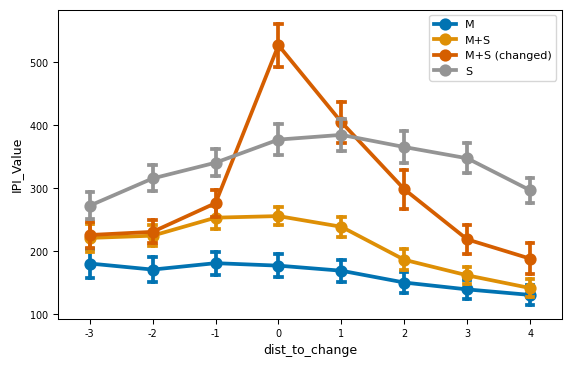

In [40]:
set_figure_style(scale="2col")
lookback_window = 7
presses_correct = utils.remove_error_trials_presses(subjs_presses)
presses_correct = utils.remove_first_block(presses_correct)

#set palette colors
palette = sns.color_palette("colorblind", 4)
sns.set_palette(palette)

all_data = pd.DataFrame({ 'SubNum': [], 'dist_to_change': [], 'IPI_Value': [], 'condition': []})

for condition, data in presses_correct.groupby('condition'):
    if condition == 'M+S (changed)':
        data['dist_to_change'] = data['N'] - 1 - data['digitChangePos']
        data = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]

    else:
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = data['N'] - 1 - digitpos
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        
        data = pd.concat(list(datas.values()), ignore_index=True)
    
    data = data.groupby(['SubNum', 'dist_to_change']).agg({
        'IPI_Value': 'median'
    }).reset_index()

    sns.pointplot(data = data, x = 'dist_to_change', y = 'IPI_Value', errorbar='se', dodge = True, capsize = 0.1, 
                  label = condition, color = custom_palette[condition])
    
    data['condition'] = condition
    #append data to all_data
    all_data = pd.concat([all_data, data], ignore_index=True)

# statistical test for each dist_to_change

for IPI in all_data['dist_to_change'].unique():
    data = all_data[all_data['dist_to_change'] == IPI]
    print(f"IPI {IPI}:")
    ttest_changed_vs_unchanged = stats.ttest_rel(data[data['condition'] == 'M+S (changed)']['IPI_Value'], 
                                                data[data['condition'] == 'M+S']['IPI_Value'])
    ttest_changed_vs_rand = stats.ttest_rel(data[data['condition'] == 'M+S (changed)']['IPI_Value'],
                                                data[data['condition'] == 'S']['IPI_Value'])
    print(f"  t-statistic = {ttest_changed_vs_unchanged.statistic}, p-value = {ttest_changed_vs_unchanged.pvalue}, df = {ttest_changed_vs_unchanged.df}")

            


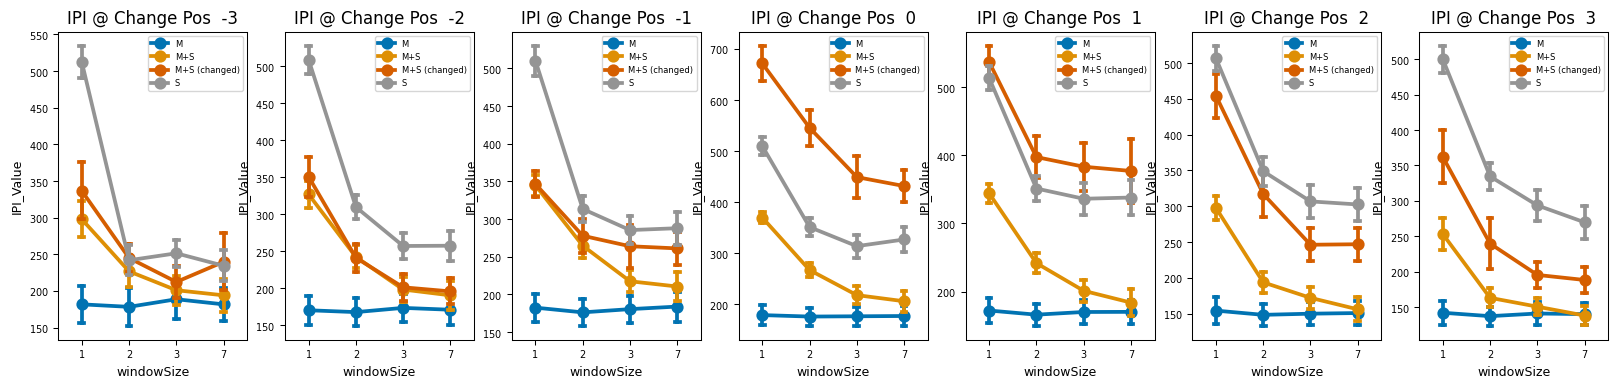

In [41]:
lookback_window = 4
presses_correct = utils.remove_error_trials_presses(subjs_presses)
presses_correct = utils.remove_first_block(presses_correct)

#set palette colors
palette = sns.color_palette("colorblind", 4)
sns.set_palette(palette)

fig , axs = plt.subplots(ncols = lookback_window * 2 - 1, figsize = (20, 4))

for lookahead in range(-lookback_window + 1, lookback_window):

    for condition, data in presses_correct[presses_correct['N'].isin(
        pos + 1 + lookahead for pos in digit_change)].groupby('condition'):

        if condition == 'M+S (changed)':
            data = data[(data['digitChangePos'] + 1 + lookahead) == (data['N'])]


        data = data.groupby(['SubNum', 'windowSize']).agg({
            'IPI_Value': 'median'
        }).reset_index()

        ax_ind = lookahead + lookback_window - 1
        sns.pointplot(data = data, x = 'windowSize', y = 'IPI_Value', errorbar='se', dodge = True, capsize = 0.1,
                        label = condition, ax = axs[ax_ind], color = custom_palette[condition])
        axs[ax_ind].set_title(f'IPI @ Change Pos  {lookahead}')

        #making the legend smaller
        axs[ax_ind].legend(loc = 'upper right', bbox_to_anchor = (1, 1), fontsize = 6)


            


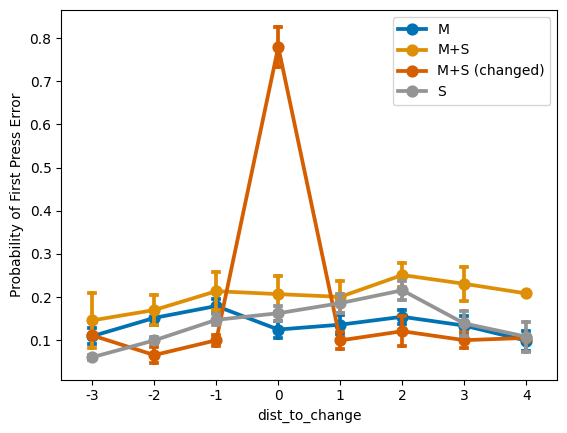

In [32]:
subjs_presses_errors = utils.remove_remaining_next_error_presses(subjs_presses).copy()
subjs_presses_errors = subjs_presses_errors[subjs_presses_errors['isPressError'] == True]

lookback_window = 7

#set palette colors
palette = sns.color_palette("colorblind", 4)
sns.set_palette(palette)

for condition, data in subjs_presses_errors.groupby('condition'):
    if condition == 'M+S (changed)':
        data['dist_to_change'] = data['N'] - 1 - data['digitChangePos']
        data = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]

    else:
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = data['N'] - 1 - digitpos
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        
        data = pd.concat(list(datas.values()), ignore_index=True)

    
    data = data.groupby(['SubNum', 'dist_to_change']).agg({
        'isPressError': 'sum'
    }).reset_index()


    total_errors = data.groupby(['SubNum']).agg({
        'isPressError': 'sum'
    }).reset_index()
    data = data.merge(total_errors, on = 'SubNum', suffixes = ('', '_total'))
    data['isPressError'] = data['isPressError'] / data['isPressError_total']

    sns.pointplot(data = data, x = 'dist_to_change', y = 'isPressError', errorbar='se', dodge = True, capsize = 0.1, 
                  label = condition, color=custom_palette[condition])
    plt.ylabel('Probability of First Press Error')

/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_2095/1687537845.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  subjs_presses_errors = subjs_presses_copy.merge(subjs_presses_errors, on = ['SubNum', 'BN', 'TN', 'N'], how = 'left',


M
     SubNum  dist_to_change  is_first_press_error  isPressError  \
0         1              -3                 False      0.954545   
2         1              -2                 False      0.977273   
4         1              -1                 False      0.981061   
6         1               0                 False      0.996212   
8         1               1                 False      0.992424   
..      ...             ...                   ...           ...   
142      10               0                 False      0.984848   
144      10               1                 False      0.973485   
146      10               2                 False      0.973485   
148      10               3                 False      0.960227   
150      10               4                 False      0.988636   

     isPressError_total  
0                    88  
2                   176  
4                   264  
6                   264  
8                   264  
..                  ...  
142        

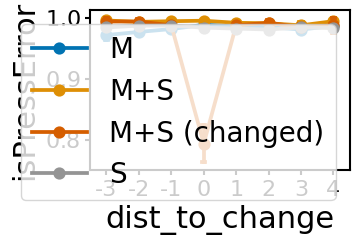

In [46]:
subjs_presses_errors = utils.remove_remaining_next_error_presses(subjs_presses).copy()
subjs_presses_errors = subjs_presses_errors[subjs_presses_errors['isPressError'] == True]
subjs_presses_errors['is_first_press_error'] = True
subjs_presses_errors = subjs_presses_errors[['SubNum', 'BN', 'TN', 'N', 'is_first_press_error']]

subjs_presses_copy = subjs_presses.copy()
subjs_presses_copy['is_first_press_error'] = False

subjs_presses_errors = subjs_presses_copy.merge(subjs_presses_errors, on = ['SubNum', 'BN', 'TN', 'N'], how = 'left', 
                                           suffixes=('', '_right')).fillna(False)
subjs_presses_errors['is_first_press_error'] = subjs_presses_errors['is_first_press_error_right']
subjs_presses_errors = subjs_presses_errors.drop(columns='is_first_press_error_right')
subjs_presses_errors

lookback_window = 7

#set palette colors
palette = sns.color_palette("colorblind", 4)
sns.set_palette(palette)

for condition, data in subjs_presses_errors.groupby('condition'):
    if condition == 'M+S (changed)':
        data['dist_to_change'] = data['N'] - 1 - data['digitChangePos']
        data = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]

    else:
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = data['N'] - 1 - digitpos
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        
        data = pd.concat(list(datas.values()), ignore_index=True)

    
    data = data.groupby(['SubNum', 'dist_to_change', 'is_first_press_error']).agg({
        'isPressError': 'count'
    }).reset_index()


    total_errors = data.groupby(['SubNum', 'dist_to_change']).agg({
        'isPressError': 'sum'
    }).reset_index()

    data = data.merge(total_errors, on = ['SubNum', 'dist_to_change'], suffixes = ('', '_total'))
    data['isPressError'] = data['isPressError'] / data['isPressError_total']

    data = data[data['is_first_press_error'] == 0]
    print(condition)
    print(data)
    sns.pointplot(data = data, x = 'dist_to_change', y = 'isPressError', errorbar='se', dodge = True, capsize = 0.1, 
                  label = condition, color = custom_palette[condition])
    # plt.ylabel('Probability of First Press Error')

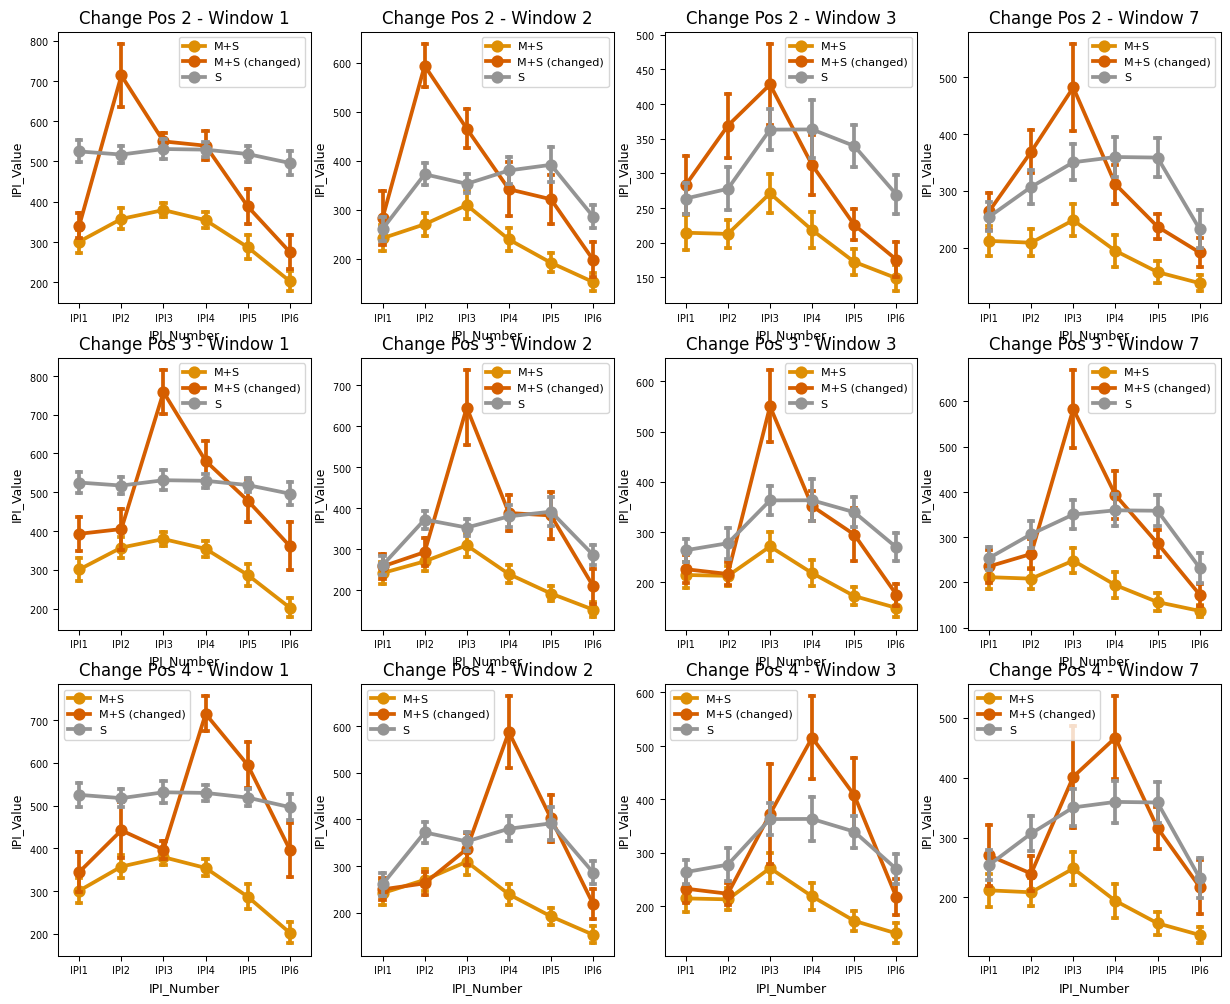

In [37]:
presses_correct = utils.remove_error_trials_presses(subjs_presses)

#set palette colors
palette = sns.color_palette("colorblind", 4)
sns.set_palette(palette)

fig, axs = plt.subplots(nrows = len(digit_change), ncols=len(windowSizes), figsize = (15, 12))




for condition, data in presses_correct.groupby('condition'):
    if condition == 'M+S (changed)':
        for pos, data_pos in data.groupby('digitChangePos'):
            for idx, (window, data_window) in enumerate(data_pos.groupby('windowSize')):
                data_window = data_window.groupby(['SubNum', 'IPI_Number']).agg({
                    'IPI_Value': 'median'
                }).reset_index()
                sns.pointplot(data = data_window, x = 'IPI_Number', y = 'IPI_Value', label = condition,
                               errorbar='se', dodge = True, capsize = 0.1, ax = axs[pos - 2, idx], color = custom_palette[condition])
                axs[pos - 2, idx].set_title(f'Change Pos {pos} - Window {window}')

    if condition == 'M+S':
        for idx, (window, data_window) in enumerate(data.groupby('windowSize')):
            data_window = data_window.groupby(['SubNum', 'IPI_Number']).agg({
                'IPI_Value': 'median'
            }).reset_index()
            for digit in range(len(digit_change)):
                sns.pointplot(data = data_window, x = 'IPI_Number', y = 'IPI_Value', label = condition,
                               errorbar='se', dodge = True, capsize = 0.1, ax = axs[digit, idx], color = custom_palette[condition])

            
    if condition == 'S':
        for idx, (window, data_window) in enumerate(data.groupby('windowSize')):
            data_window = data_window.groupby(['SubNum', 'IPI_Number']).agg({
                'IPI_Value': 'median'
            }).reset_index()
            for digit in range(len(digit_change)):
                sns.pointplot(data = data_window, x = 'IPI_Number', y = 'IPI_Value', label = condition,
                               errorbar='se', dodge = True, capsize = 0.1, ax = axs[digit, idx], color = custom_palette[condition])

            
